In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm, trange

import sys
sys.path.append('../docker/damaris-scripts/')
from machine_learning_across import *

data_basepath = '/home/kjetil/projects/across/machinelearning/across_review/ert_example/'

/home/kjetil/projects/phnn_gitlab/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = NeuralNetwork()

In [3]:
def generate_sample(nx, ny, nz):
    parameter = np.random.uniform(0.0, 1.0)
    x, y, z = np.mgrid[0:1:nx*1j, 0:1:ny*1j, 0:1:nz*1j]
    
    return (x + y + parameter * z).astype(np.float32).reshape(1, nx, ny, nz)

def generate_data(ns, nx, ny, nz):
    all_samples = []
    for _ in range(ns):
        all_samples.append(generate_sample(nx, ny, nz))
    
    return torch.tensor(all_samples)

def get_data(path):
    data = reorder_data(np.loadtxt(path))
    shape = data.shape
    return data.reshape(1, *shape)

def get_all_data_from_file(basepath):
    all_data_files = glob.glob(os.path.join(basepath, 'data_big/larger_data_*.txt'))
    all_data = []
    
    for fname in all_data_files[:10]:
        try:
            new_data = get_data(fname).astype(np.float32)
            all_data.append(new_data)
        except IndexError:
            pass
    print(f"{len(all_data)=}")
    return torch.tensor(all_data)

In [4]:
data = get_all_data_from_file(data_basepath)

len(all_data)=9


/tmp/ipykernel_1052274/3138647279.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.tensor(all_data)


In [5]:
print(data.shape)
print(f"{model.dnn_down(data).shape=}")
print(f"{model.forward(data).shape=}")
print(f"{data.shape=}")
print(f"{nn.MSELoss()(model.forward(data), data)=}")

torch.Size([9, 1, 16, 20, 20])
model.dnn_down(data).shape=torch.Size([9, 1, 4, 5, 5])
model.forward(data).shape=torch.Size([9, 1, 16, 20, 20])
data.shape=torch.Size([9, 1, 16, 20, 20])
nn.MSELoss()(model.forward(data), data)=tensor(121960.7656, grad_fn=<MseLossBackward0>)


In [6]:
data.shape

torch.Size([9, 1, 16, 20, 20])

100%|██| 100/100 [00:00<00:00, 215.59it/s, epoch=100, shape=torch.Size([9, 1, 16, 20, 20]), train_loss=1.12e+5]


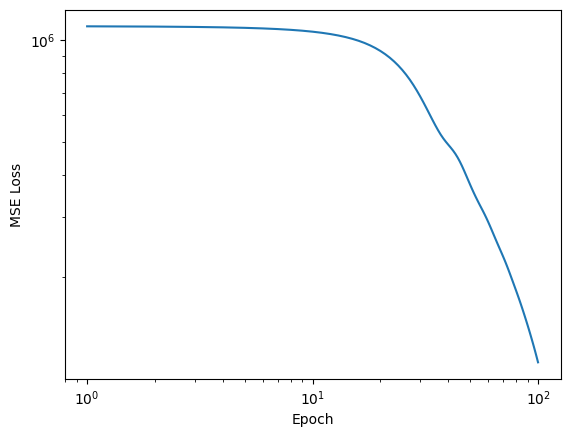

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 100
loss_function = nn.MSELoss()
train_loader = torch.utils.data.DataLoader(data, batch_size=32, num_workers=0)
loss_per_epoch = []
with trange(1, n_epochs + 1) as t:
    for epoch in t:
        train_loss = 0.0

        for samples in train_loader:
            optimizer.zero_grad()
            outputs = model(samples)
            loss = loss_function(outputs, samples)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*samples.size(0)

        train_loss = train_loss/len(train_loader)
        t.set_postfix(epoch=epoch, train_loss=train_loss, shape=samples.shape)
        loss_per_epoch.append(train_loss)
        
plt.loglog(np.arange(1, n_epochs+1), loss_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [8]:
x = torch.tensor(np.zeros((4,5)))

In [9]:
model.dnn_down(data[0, :, :]).shape

torch.Size([1, 4, 5, 5])

ValueError: x and y can be no greater than 2D, but have shapes (16,) and torch.Size([16, 20, 20])

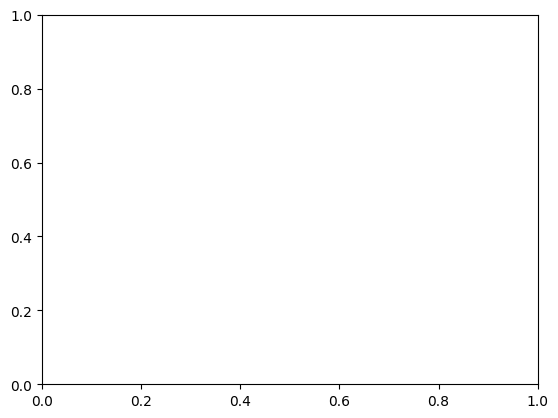

In [10]:
plt.plot(data[0, 0, :], label='True (300 datapoints)')
plt.plot(model.forward(data[0,:,:]).detach().numpy()[0,:], label='CAE (75 datapoints)')
plt.plot(np.repeat(data[0, 0, ::4], 4), '--', label='75 datapoints (no CAE)')
plt.xlabel("Linearized xyz index")
plt.ylabel("Pressure")
plt.legend()


In [ ]:
model_ert = NeuralNetwork()
model_ert.load_state_dict(torch.load('../ert_example/data_learning/training_model.torch'))
model_ert.eval()

In [ ]:
plt.plot(data[0, 0, :], label='True (300 datapoints)')
plt.plot(model_ert.forward(data[0,:,:]).detach().numpy()[0,:], label='CAE (75 datapoints)')
plt.plot(np.repeat(data[0, 0, ::4], 4), '--', label='75 datapoints (no CAE)')
plt.xlabel("Linearized xyz index")
plt.ylabel("Pressure")
plt.legend()


In [ ]:
plt.plot(data[0, 0, :], label='True (300 datapoints)')
plt.plot(data[0, 0, ::10].repeat(10), label='True (300 datapoints)')

In [ ]:
z = np.zeros((3, 10, 10))
x = data[0, 0, :]
nx = 10
ny = 10
nz = 3
for i in range(nz):
    for j in range(ny):
        for k in range(nx):
            index = i*ny * nx + j * nx + i
            z[i,j,k] = x[index]

In [ ]:
plt.pcolormesh(z.reshape(3, 100))
plt.colorbar()

In [ ]:
data[0, 0, :]

In [ ]:
plt.pcolormesh(data[8,0,5,:,:])